# Corporate Decarbonization Research
---

## Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

---

## Data Cleaning

In this section of the notebook, I will be importing our data and cleaning/standardizing our datasets.

In [2]:
foodag = pd.read_csv('data/food&ag.csv')
energy = pd.read_csv('data/energy.csv')
auto = pd.read_csv('data/auto.csv')
tech = pd.read_csv('data/tech.csv')


In [3]:
# Add sector columns to concatenate df's

foodag['SECTOR'] = ['Food & Agriculture'] * len(foodag['COMPANY NAME'])
energy['SECTOR'] = ['Energy'] * len(energy['COMPANY NAME'])
auto['SECTOR'] = ['Auto'] * len(auto['COMPANY NAME'])
tech['SECTOR'] = ['Tech'] * len(tech['COMPANY NAME'])
foodag.shape, energy.shape, auto.shape, tech.shape


((39, 12), (52, 12), (67, 13), (34, 12))

In [4]:
# clean tech to standardize columns across all df's, shorten CI column name

tech = tech.rename(columns={'CARBON INTENSITY\n(Scope 1 & 2 g CO2e/ $ Sales) \ncalculated' :
'CARBON INTENSITY\n(Scope 1 & 2 g CO2e / $ Sales)'})

df_array = [foodag, energy, auto, tech]
for df in df_array:
    df.rename(columns={'CARBON INTENSITY\n(Scope 1 & 2 g CO2e / $ Sales)': 'CARBON INTENSITY'}, inplace=True)

# convert CI to type float
energy['CARBON INTENSITY'] = energy['CARBON INTENSITY'].str.replace(',', '').astype(float)


In [5]:
# concatenate dataframes together

sectors = pd.concat([foodag, energy, auto, tech])
sectors = sectors.drop(columns='SCOPE 1 + SCOPE 2 EMISSIONS')
sectors.shape

(192, 12)

In [6]:
# convert revenue's to USD

def toUSD(i):
    dic = {
    'AUD': 0.75,   # 1 AUD to USD
    'CAD': 0.78,   # 1 CAD to USD
    'CHF': 1.09,   # 1 CHF to USD
    'DKK': 0.15,   # 1 DKK to USD
    'EUR': 1.16,   # 1 EUR to USD
    'GBP': 1.37,   # 1 GBP to USD
    'JPY': 0.009,  # 1 JPY to USD
    'KRW': 0.0009, # 1 KRW to USD
    'NOK': 0.11,   # 1 NOK to USD
    'RUB': 0.014,  # 1 RUB to USD
    'SEK': 0.11,   # 1 SEK to USD
    'RMB': 7.29,   # 1 RMB to USD
    'TWD' : 0.03,  # 1 TWD to USD
    'USD': 1       # No Change    
    }
    if (i[0] != 'nan') & (i[1] != 'nan'):
        return i[1] * dic[i[0]] # The revenue multiplied by the corresponding USD conversion rate

# sectors['Revenue (USD)'] = sectors.apply(toUSD, 'TOTAL REVENUE (miillion $)')

In [7]:
# Function for creating column with [Currency, Revenue]

def currAndRev(df):
    new_col = []
    for i in np.arange(df.shape[0]):
        new_col.append([df['CURRENCY'].values[i], df['TOTAL REVENUE (miillion $)'].values[i]])
    df['REVENUE IN USD'] = new_col

currAndRev(sectors)


In [8]:
# create a copy of sectors with no null values and create USD Revenue column

sectors_nona = sectors.copy().dropna()
sectors_nona['USD REVENUE'] =  sectors_nona.loc[:, 'REVENUE IN USD'].apply(toUSD)

sectors_nona = sectors_nona.drop(columns=['REVENUE IN USD'])
sectors_nona.head()

,COMPANY NAME,YEAR,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CURRENCY,CARBON INTENSITY,COUNTRY OF ORIGIN,SUBMIT TO CDP,SECTOR,USD REVENUE
0,Anheuser-Busch InBev,2018,3700760.0,2383505.0,24431839.0,30516104.0,54619.0,USD,111.39,Belgium,Yes,Food & Agriculture,54619.00
1,Anheuser-Busch InBev,2019,3600710.0,2215902.0,26484447.0,32301059.0,52329.0,USD,111.15,Belgium,Yes,Food & Agriculture,52329.00
2,Anheuser-Busch InBev,2020,3081905.0,2227758.0,23652933.0,28962596.0,46881.0,USD,113.26,Belgium,Yes,Food & Agriculture,46881.00
3,Anheuser-Busch InBev,2021,2953896.0,2243990.0,26527444.0,31725330.0,54304.0,USD,95.72,Belgium,Yes,Food & Agriculture,54304.00
4,Danone,2018,753461.0,959554.0,24885804.0,26598819.0,24651.0,EUR,69.49,France,Yes,Food & Agriculture,28595.16


In [9]:
sectors_nona['ADJUSTED CI'] = ((sectors_nona['SCOPE 1'] + sectors_nona['SCOPE 2 (location-based)']) / sectors_nona['USD REVENUE']).round(2)
sectors_nona.head()

,COMPANY NAME,YEAR,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CURRENCY,CARBON INTENSITY,COUNTRY OF ORIGIN,SUBMIT TO CDP,SECTOR,USD REVENUE,ADJUSTED CI
0,Anheuser-Busch InBev,2018,3700760.0,2383505.0,24431839.0,30516104.0,54619.0,USD,111.39,Belgium,Yes,Food & Agriculture,54619.00,111.39
1,Anheuser-Busch InBev,2019,3600710.0,2215902.0,26484447.0,32301059.0,52329.0,USD,111.15,Belgium,Yes,Food & Agriculture,52329.00,111.15
2,Anheuser-Busch InBev,2020,3081905.0,2227758.0,23652933.0,28962596.0,46881.0,USD,113.26,Belgium,Yes,Food & Agriculture,46881.00,113.26
3,Anheuser-Busch InBev,2021,2953896.0,2243990.0,26527444.0,31725330.0,54304.0,USD,95.72,Belgium,Yes,Food & Agriculture,54304.00,95.72
4,Danone,2018,753461.0,959554.0,24885804.0,26598819.0,24651.0,EUR,69.49,France,Yes,Food & Agriculture,28595.16,59.91


In [10]:
# Replace 'Submit to CDP' values with True and False for performing categorical data analysis

sectors['SUBMIT TO CDP'] = sectors['SUBMIT TO CDP'].replace({
    'Yes' : True,
    'No' : False
})

sectors.head()

,COMPANY NAME,YEAR,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CURRENCY,CARBON INTENSITY,COUNTRY OF ORIGIN,SUBMIT TO CDP,SECTOR,REVENUE IN USD
0,Anheuser-Busch InBev,2018,3700760.0,2383505.0,24431839.0,30516104.0,54619.0,USD,111.39,Belgium,True,Food & Agriculture,"[USD, 54619.0]"
1,Anheuser-Busch InBev,2019,3600710.0,2215902.0,26484447.0,32301059.0,52329.0,USD,111.15,Belgium,True,Food & Agriculture,"[USD, 52329.0]"
2,Anheuser-Busch InBev,2020,3081905.0,2227758.0,23652933.0,28962596.0,46881.0,USD,113.26,Belgium,True,Food & Agriculture,"[USD, 46881.0]"
3,Anheuser-Busch InBev,2021,2953896.0,2243990.0,26527444.0,31725330.0,54304.0,USD,95.72,Belgium,True,Food & Agriculture,"[USD, 54304.0]"
4,Danone,2018,753461.0,959554.0,24885804.0,26598819.0,24651.0,EUR,69.49,France,True,Food & Agriculture,"[EUR, 24651.0]"


---

## Cross-Sector Exploratory Data Analysis (EDA)

In [11]:
# Average scope and revenue values by sector in descending order of average total emissions

sectors.groupby('SECTOR').mean(numeric_only=True).drop(columns=['YEAR']).round(0).sort_values(by='TOTAL EMISSIONS', ascending=False)

,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CARBON INTENSITY
SECTOR,,,,,,
Energy,49572817.0,7985842.0,429716132.0,390728248.0,365796.0,1246.0
Auto,1149196.0,2299911.0,190202075.0,193927442.0,118852.0,44.0
Food & Agriculture,1632704.0,1226111.0,41175943.0,44034758.0,44966.0,65.0
Tech,2495589.0,5359486.0,27581036.0,35436111.0,213245.0,58.0


In [12]:
rev_summary = sectors_nona.groupby('SECTOR').mean(numeric_only=True).round(0)[['USD REVENUE']].rename(columns={'USD REVENUE' : 'Mean USD Revenue'}).sort_values(by='Mean USD Revenue', ascending=False)
rev_summary

,Mean USD Revenue
SECTOR,
Tech,166592.0
Auto,111464.0
Energy,102103.0
Food & Agriculture,50114.0


In [13]:
sectors.groupby('COMPANY NAME').mean(numeric_only=True).drop(columns=['YEAR']).sort_values(by='TOTAL EMISSIONS', ascending=False)

,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CARBON INTENSITY
COMPANY NAME,,,,,,
Shell,6.600000e+07,1.050000e+07,1.019486e+09,1.095986e+09,3.011285e+05,273.457500
Chevron,5.975000e+07,3.250000e+06,1.026750e+09,1.089750e+09,1.372110e+05,474.445000
Gazprom,8.753618e+07,6.279702e+06,1.127929e+09,9.397628e+08,3.554709e+06,NaN
Volkswagen,4.399262e+06,4.672319e+06,3.906633e+08,3.997349e+08,2.638767e+05,35.241667
BP,4.322500e+07,4.175000e+06,3.560667e+08,3.144500e+08,2.149068e+05,250.992500
Honda,1.250049e+06,3.443023e+06,2.886172e+08,2.933103e+08,1.037518e+05,45.204000
Equinor,1.374247e+07,1.895245e+05,2.782205e+08,2.921525e+08,7.017300e+04,212.770000
Fiat-Chrysler,1.227754e+06,2.414369e+06,2.668018e+08,2.706001e+08,1.365630e+05,27.941667
General Motors,1.533818e+06,3.849410e+06,2.564534e+08,2.618366e+08,1.304254e+05,41.000000


In [14]:
country = sectors.groupby('COUNTRY OF ORIGIN').mean(numeric_only=True).drop(columns=['YEAR', 'TOTAL REVENUE (miillion $)']).round(0).sort_values(by='TOTAL EMISSIONS', ascending=False)
country

,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,CARBON INTENSITY
COUNTRY OF ORIGIN,,,,,
"United Kingdom, Netherlands",66000000.0,10500000.0,1.019486e+09,1.095986e+09,273.0
Russsia,72418092.0,13464851.0,7.015146e+08,9.397628e+08,NaN
United Kingdom,43225000.0,4175000.0,3.560667e+08,3.144500e+08,251.0
Norway,13742474.0,189524.0,2.782205e+08,2.921525e+08,213.0
"Italy, United States",1227754.0,2414369.0,2.668018e+08,2.706001e+08,28.0
Germany,2094966.0,2623166.0,2.120192e+08,2.169266e+08,24.0
Japan,795872.0,1976986.0,1.866242e+08,1.893971e+08,24.0
United States,13699449.0,3512779.0,1.517251e+08,1.584735e+08,165.0
China,25552117.0,9301497.0,7.942017e+07,1.236736e+08,2344.0


The first row corresponds to Shell, last row corresponds to Molson Coors

---

## Helper Functions

In [15]:
# graph using matplotlib

def graphCoEmissions(df, co_name, years_arr):
    # format plots and add right axis for CI
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # create x axis array
    years = df.loc[df['COMPANY NAME']==co_name, 'YEAR']

    # create bar chart stacks and CI array
    scope1 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 1']
    scope2 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 2 (location-based)']
    scope3 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 3']
    ci = df.loc[df['COMPANY NAME']==co_name, 'CARBON INTENSITY']

    # plot bar chart
    b1 = ax1.bar(years, scope1, color=plt.cm.plasma(0))
    b2 = ax1.bar(years, scope2, bottom=scope1, color=plt.cm.plasma(0.4))
    b3 = ax1.bar(years, scope3, bottom=scope1+scope2, color=plt.cm.plasma(0.8))

    # plot CI
    l1 = ax2.plot(years, ci, color = plt.cm.viridis(0.5), marker = 'o')

    # finish formatting plots
    ax1.set_xticks(years_arr)
    ax1.set_ylim(0, max(scope1+scope2+scope3)+9000000)
    ax2.set_ylim(0, max(ci)+20)

    # combine and add legend
    lines = [b1, b2, b3, l1]
    labels = ['SCOPE 1','SCOPE 2','SCOPE 3','CI' ]
    ax1.legend(lines, labels, loc='lower left', bbox_to_anchor=(1, 1))


    # add labels and titles
    plt.suptitle('Annual GHG Emissions', fontsize=14, fontweight='bold')
    plt.title(co_name, fontsize=10)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Carbon Emissions (metric ton CO2e)')
    ax2.set_ylabel('Carbon Intensity (g CO2e / $ million)')

    

In [16]:
# graph using plotly

import plotly.graph_objects as go

def graphCoEmissionsPlotly(df, co_name, years_arr):
    # format plots and add right axis for CI
    # fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()

    # create x axis array
    years = df.loc[df['COMPANY NAME']==co_name, 'YEAR']

    # create bar chart stacks and CI array
    scope1 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 1']
    scope2 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 2 (location-based)']
    scope3 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 3']
    ci = df.loc[df['COMPANY NAME']==co_name, 'CARBON INTENSITY']


     # create stacked bar chart traces
    trace_scope1 = go.Bar(x=years, y=scope1, name='Scope 1', marker=dict(color='rgba(0, 0, 255, 0.7)'))
    trace_scope2 = go.Bar(x=years, y=scope2, name='Scope 2', marker=dict(color='rgba(0, 255, 0, 0.7)'))
    trace_scope3 = go.Bar(x=years, y=scope3, name='Scope 3', marker=dict(color='rgba(255, 0, 0, 0.7)'))

    # create line chart trace for CI
    trace_ci = go.Scatter(x=years, y=ci, mode='markers+lines', name='Carbon Intensity', yaxis='y2',
                          marker=dict(color='rgba(255, 165, 0, 0.7)'))

    # combine traces into data list
    data = [trace_scope1, trace_scope2, trace_scope3, trace_ci]

    # create layout
    layout = go.Layout(
        title=dict(text=co_name+' - Annual GHG Emissions', x=0.5),
        xaxis=dict(tickvals=years_arr, title='Year'),
        yaxis=dict(title='Carbon Emissions (metric ton CO2e)', range=[0, max(scope1+scope2+scope3)+9000000]),
        yaxis2=dict(title='Carbon Intensity (g CO2e / $ million)', overlaying='y', side='right', range=[0, max(ci)+20]),
        barmode='stack',
        showlegend=True,
        height=650,
        width=800,
        margin=dict(r=1.2)
    )

    # create figure
    fig = go.Figure(data=data, layout=layout)

    # show the figure
    fig.show()

---

## Visualizations

In [17]:
fig = px.scatter(sectors, x='SCOPE 1', y='SCOPE 2 (location-based)', color='SECTOR', hover_data=['COMPANY NAME'])
fig.update_layout(title='Scope 1 vs. Scope 2 Across All Sectors')
fig.show()

In [18]:
fig = px.scatter(sectors, x='SCOPE 2 (location-based)', y='SCOPE 3', color='SECTOR', hover_data=['COMPANY NAME'])
fig.update_layout(title='Scope 2 vs. Scope 3 Across All Sectors')
fig.show()

In [19]:
# Way too wide of a range for carbon intensity with adjusted revenue values, 
# could potentially be because revenue values are not standardized, auto rev's may not represent millions of dollars

sectors_nona['ADJUSTED CI'].sort_values()

10         0.25
13         2.58
14         2.84
12         3.42
11         3.52
        ...    
25     52302.87
26     53196.40
27     56088.89
29     97597.93
28    113127.44
Name: ADJUSTED CI, Length: 150, dtype: float64

### Food & Agriculture Emissions Charts

/var/folders/xy/l19hywx53pz7j31v4v0hrk5w0000gn/T/ipykernel_21183/2626075236.py:33: UserWarning:

Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries



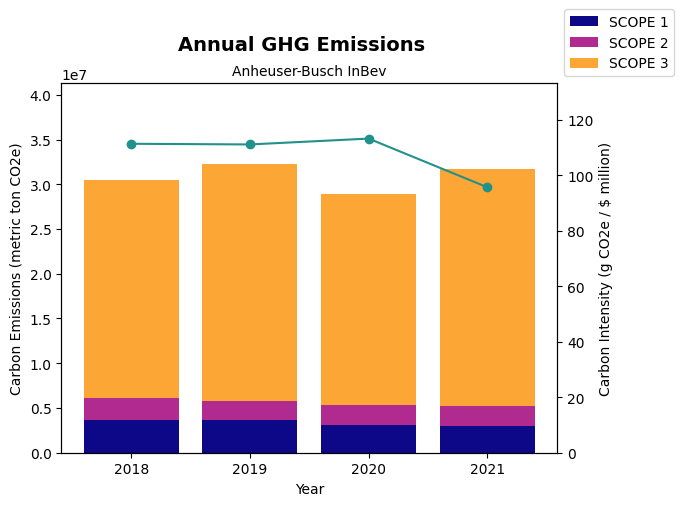

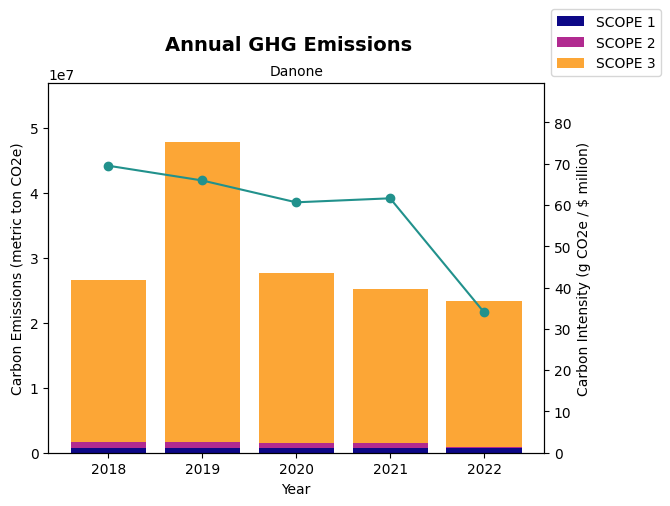

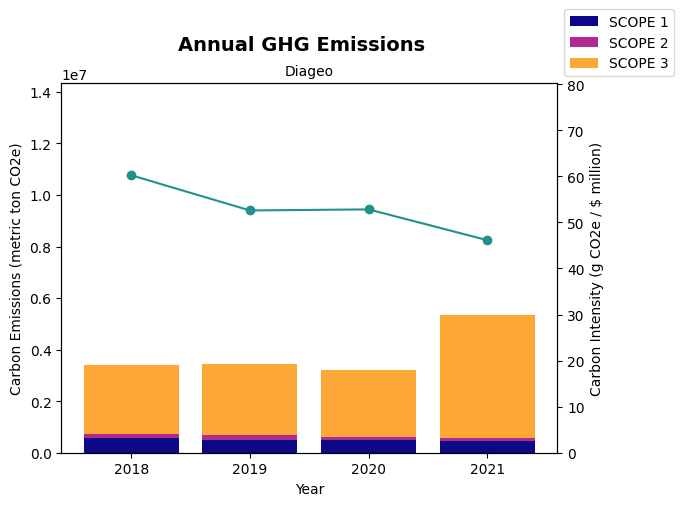

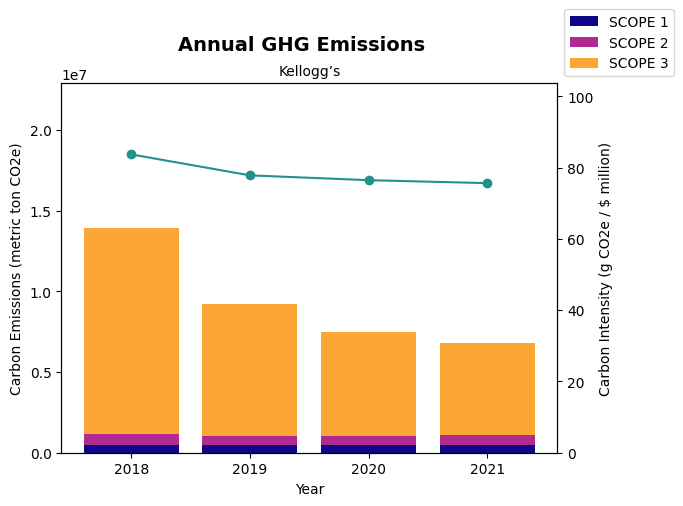

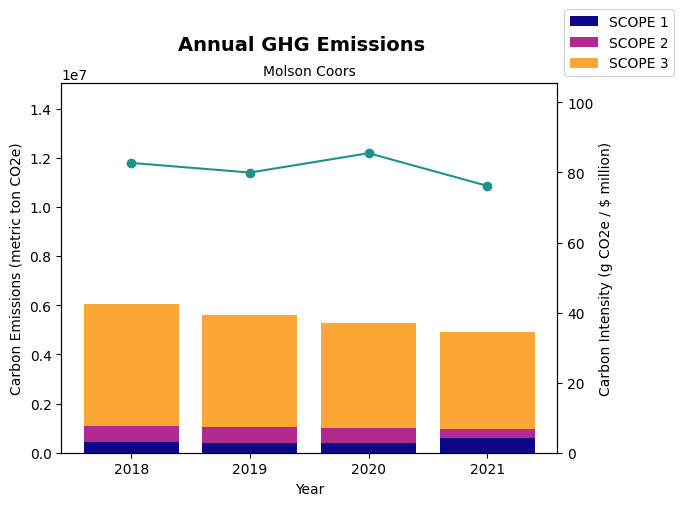

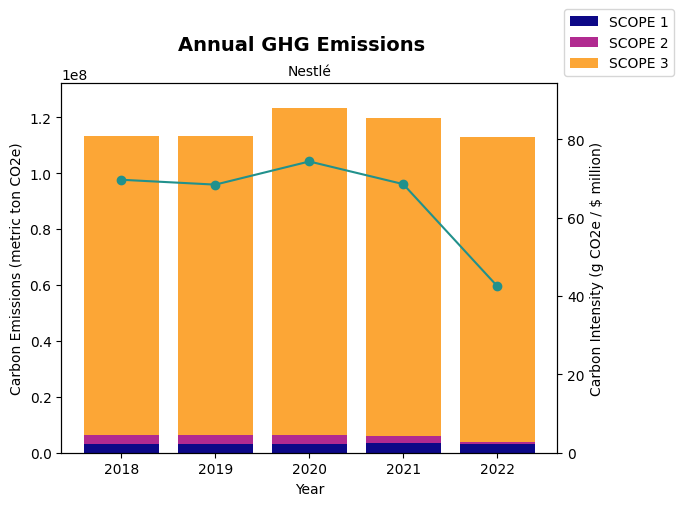

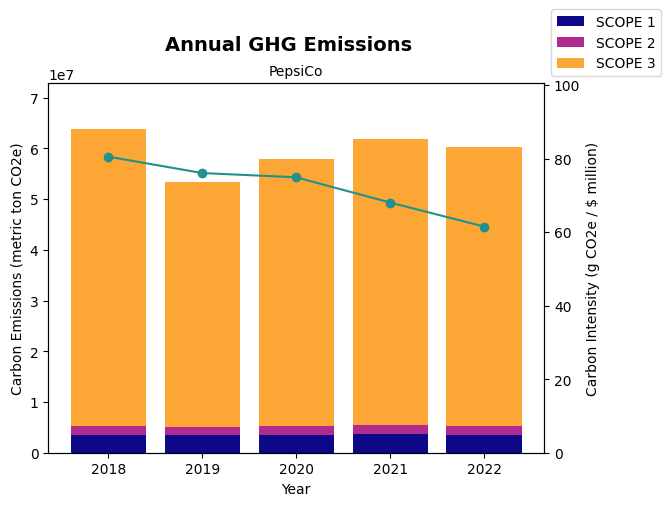

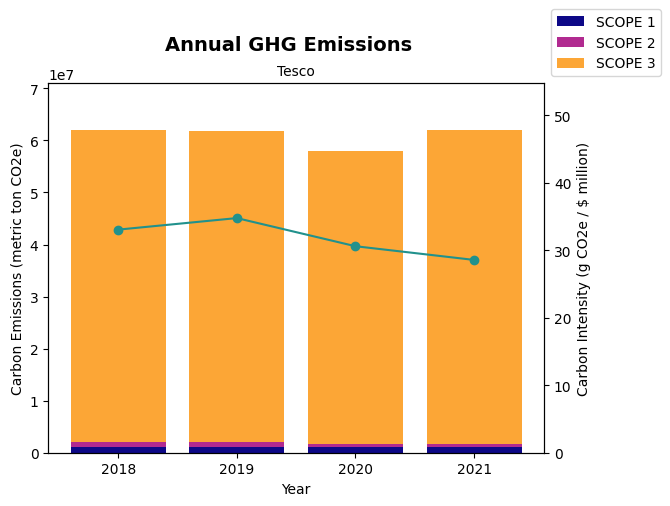

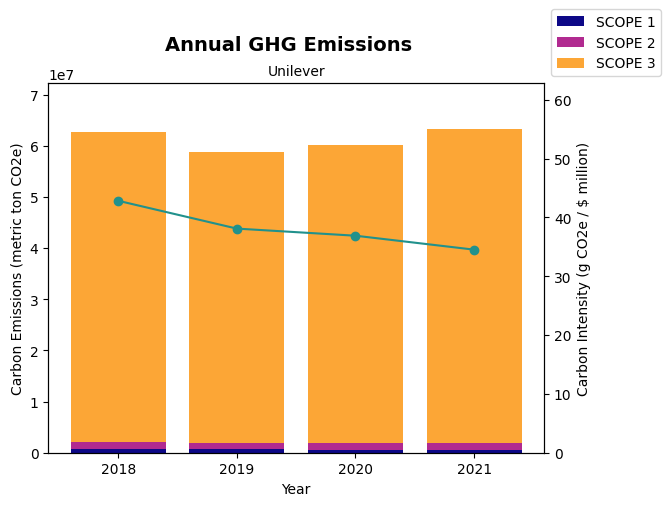

In [20]:
# graph charts for every company

yrs1 = [2017, 2018, 2019, 2020]
yrs2 = [2018, 2019, 2020, 2021]
yrs3 = [2018, 2019, 2020, 2021, 2022]
yrs4 = [np.arange(2017, 2023)]

for company in foodag['COMPANY NAME'].unique():
    num_years = foodag.loc[foodag['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissions(foodag, company, yrs2)
    else:
        graphCoEmissions(foodag, company, yrs3)

In [21]:
# another way to plot charts

for company in foodag['COMPANY NAME'].unique():
    num_years = foodag.loc[foodag['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissionsPlotly(foodag, company, yrs2)
    else:
        graphCoEmissionsPlotly(foodag, company, yrs3)


### Energy Emissions Charts

In [22]:
# graph energy charts

for company in energy['COMPANY NAME'].unique():
    num_years = energy.loc[energy['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissionsPlotly(energy, company, yrs2)
    else:
        graphCoEmissionsPlotly(energy, company, yrs3)

### Tech Emissions Charts

In [23]:
# graph tech charts

for company in tech['COMPANY NAME'].unique():
    num_years = tech.loc[tech['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissionsPlotly(tech, company, yrs2)
    else:
        graphCoEmissionsPlotly(tech, company, yrs3)

### Auto Emissions Charts

In [24]:
for company in auto['COMPANY NAME'].unique():
    num_years = auto.loc[auto['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissionsPlotly(auto, company, yrs2)
    else:
        graphCoEmissionsPlotly(auto, company, yrs3)